# 이상치 제거

- 이상치Anomailies = 극단치Outlier + 특이치Novelites
- 극단치는 제거해야 모형에 좋습니다.(데이터 수집 상의 오류, 인위적인 변형을 일으킨 데이터 등 자연스럽게 발생하지 않은 것)
- 특이치는 남겨둬야 모형에 좋습니다. (실제로 벌어진 일)   
참고 : https://hoya012.github.io/blog/anomaly-detection-overview-1/

## 1. Data 수집 및 이상치 확인 


(주가 Low 가 해당일의 최고치 주가보다 높은 현상 발견)

In [83]:
import requests
import os
import pandas as pd

In [84]:
url="https://query1.finance.yahoo.com/v7/finance/download/%5EKS11?period1=867715200&period2=1597276800&interval=1d&events=history"
response=requests.get(url)

In [85]:
csv_file=os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/kospi.csv'

In [86]:
with open(csv_file, 'w') as fp:
    fp.write(response.text)

In [87]:
df=pd.read_csv(csv_file)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,744.979980,760.520020,744.669983,758.030029,758.030029,0.0
1,1997-07-02,763.390015,777.289978,763.390015,777.289978,777.289978,0.0
2,1997-07-03,778.820007,782.169983,773.270020,775.260010,775.260010,0.0
3,1997-07-04,776.020020,783.239990,773.900024,781.700012,781.700012,0.0
4,1997-07-07,777.700012,777.750000,772.140015,773.510010,773.510010,0.0


In [88]:
df['Date']=pd.to_datetime(df['Date'])

In [89]:
print("dtypes:\n{} \n------------------\n 오류치 :\n{}".format(df.dtypes, df.isna().sum()))

dtypes:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object 
------------------
 오류치 :
Date           0
Open         150
High         150
Low          150
Close        150
Adj Close    150
Volume       150
dtype: int64


In [90]:
df.dropna(axis=0, inplace=True)
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [91]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 

Text(0, 0.5, 'price')

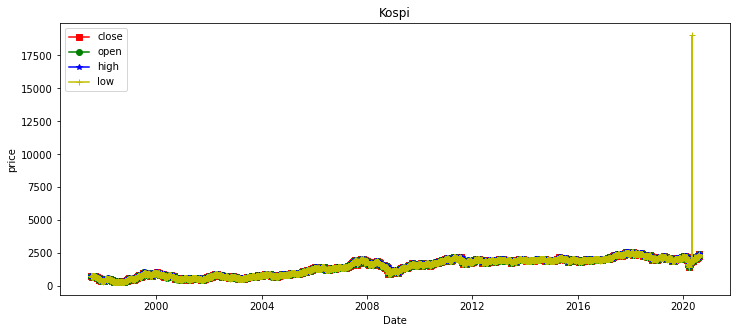

In [92]:
plt.rcParams["figure.figsize"] = (12,5)
plt.plot(df['Date'], df.Close, marker='s', color='r', label='close')
plt.plot(df.Date, df.Open, marker='o', color='g', label='open')
plt.plot(df.Date, df.High, marker='*', color='b', label='high')
plt.plot(df.Date, df.Low, marker='+', color='y', label='low')
plt.title('Kospi')
plt.legend()
plt.xlabel('Date')
plt.ylabel('price')
#수집한 주가를 그래프로 표현함

In [93]:
(df.Low>df.High).sum()
#이상치가 하나 발견됨

1

## 2. 이상치 제거 방법들

## 1) 통계적 방법

In [94]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

In [95]:
result=seasonal_decompose(df.Close, model='additive', two_sided=True, period=50, extrapolate_trend=True)

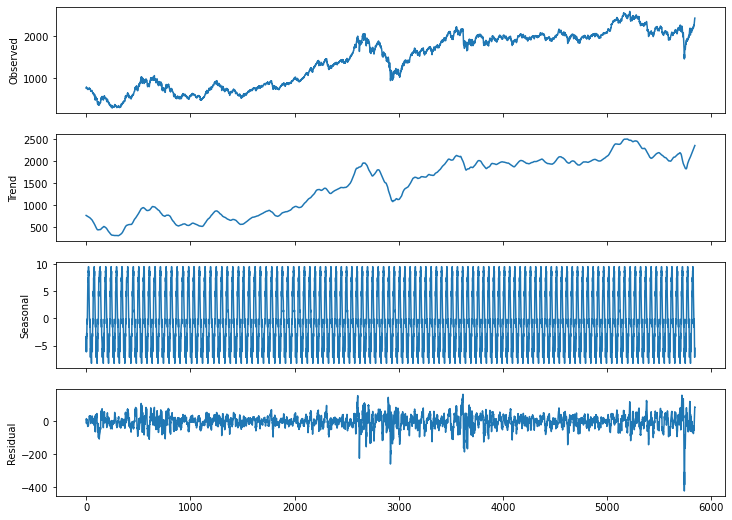

In [98]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

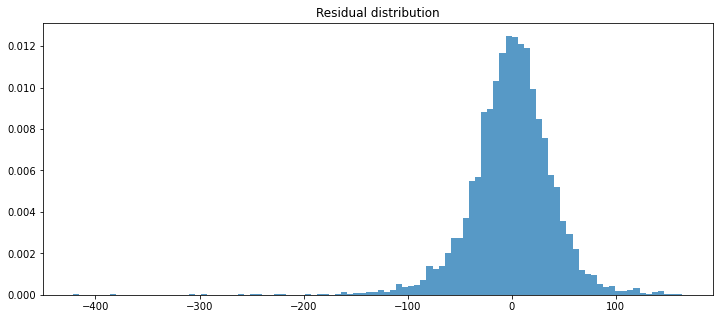

In [104]:
#Residual 재확인

plt.hist(result.resid,100, density=True,alpha=0.75)
plt.title('Residual distribution')
plt.show()

In [109]:
from statsmodels.stats.weightstats import ztest

r=result.resid.values
z_stat, p_value=ztest(r)
print(p_value)
print(z_stat)

0.7104491853632722
-0.37125288663680267


In [111]:
#데이터가 어느정도 정규분포를 따르므로, 3시그마 이상의 값들을 이상치로 치부해보자
up=r.mean()+r.std()*3
down=r.mean()-r.std()*3

In [114]:
len(r[(r>up)|(r<down)])

71

In [115]:
#71개의 이상치 후보군은 대부분 특이치(Novelty)
# 그래도 Supervised로 5682개를 하나하나 확인하기는 어려웠는데, 71개로 줄었으니 이제는 개별적으로 비교 가능
# 한계 : 여전히 개별 수작업이 많이 들어간다

## 2) Kmeans

In [131]:
#Seasonal decompose 후 residual 값을 이용해 Kmeans 로 이상치 분석
residual=pd.DataFrame()
for feat in ['Open', 'Close', "High", 'Low', 'Volume']:
    result=seasonal_decompose(df[feat], two_sided=True, period=50, model='additive',extrapolate_trend=50)
    residual[feat]=result.resid.values

In [133]:
residual.head()

,Open,Close,High,Low,Volume
0,-83.959136,-71.730120,-69.435805,-80.518324,188102.102315
1,-62.648876,-51.887393,-50.466510,-59.615305,30587.242665
2,-46.615877,-50.076479,-44.312142,-47.759532,-1937.722247
3,-45.581104,-40.772796,-39.659293,-43.016430,264271.891788
4,-40.971532,-42.807221,-41.194982,-41.001598,209410.075999


In [141]:
#Kmean 를 위한 전처리 : 거리기반의 클러스터링 이므로 데이터 별 scaling 필요
import sklearn
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(residual)
norm_resid=scaler.transform(residual)

In [142]:
norm_resid

array([[-2.11078435e+00, -1.78975878e+00, -1.81469803e+00,
        -3.55461884e-01,  2.10763080e-02],
       [-1.57245471e+00, -1.29206209e+00, -1.31620670e+00,
        -2.63587404e-01,  3.44552935e-03],
       [-1.16743672e+00, -1.24664060e+00, -1.15447694e+00,
        -2.11478046e-01, -1.95018959e-04],
       ...,
       [ 1.40187705e+00,  2.10596922e+00,  2.03518846e+00,
         1.51184809e+00,  6.12871509e-02],
       [ 1.72956122e+00,  2.26635573e+00,  1.93639106e+00,
         1.51714054e+00,  3.75265169e-02],
       [ 2.56782539e+00,  2.24061341e+00,  2.43952406e+00,
         1.61253875e+00,  1.51850684e-02]])

In [148]:
from sklearn.cluster import KMeans
Kmeans=KMeans(n_clusters=10, random_state=0).fit(norm_resid)

In [165]:
residual['label']=Kmeans.labels_

residual['anomaly']=0
residual.loc[residual['label'].isin([2,3,7]), 'anomaly']=1

In [166]:
residual.head()

,Open,Close,High,Low,Volume,label,anomaly
0,-83.959136,-71.730120,-69.435805,-80.518324,188102.102315,0,0
1,-62.648876,-51.887393,-50.466510,-59.615305,30587.242665,0,0
2,-46.615877,-50.076479,-44.312142,-47.759532,-1937.722247,0,0
3,-45.581104,-40.772796,-39.659293,-43.016430,264271.891788,0,0
4,-40.971532,-42.807221,-41.194982,-41.001598,209410.075999,0,0


Text(0, 0.5, 'Low')

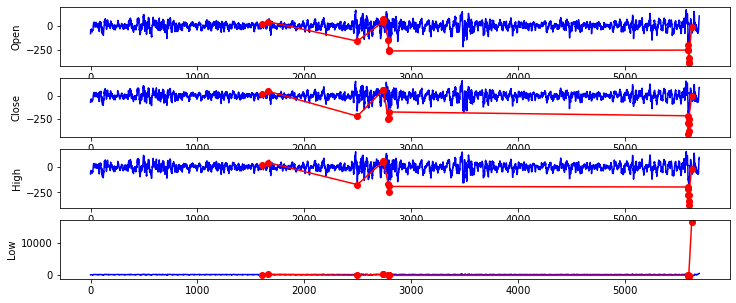

In [189]:
fig, axes=plt.subplots(ncols=1,nrows=4)
residual.loc[residual['anomaly']==0,'Open'].plot(ax=axes[0], color='b')
axes[0].plot(residual.loc[residual['anomaly']==1,'Open'], color='r', marker='o')
axes[0].set_ylabel('Open')

residual.loc[residual['anomaly']==0,'Close'].plot(ax=axes[1], color='b')
axes[1].plot(residual.loc[residual['anomaly']==1,'Close'], color='r', marker='o')
axes[1].set_ylabel('Close')


residual.loc[residual['anomaly']==0,'High'].plot(ax=axes[2], color='b')
axes[2].plot(residual.loc[residual['anomaly']==1,'High'], color='r', marker='o')
axes[2].set_ylabel('High')

residual.loc[residual['anomaly']==0,'Low'].plot(ax=axes[3], color='b')
axes[3].plot(residual.loc[residual['anomaly']==1,'Low'], color='r', marker='o')
axes[3].set_ylabel('Low')


,Open,Close,High,Low,Volume,count,anomaly
0,-1.298298,-1.289032,-1.327577,-0.236073,-0.095653,615,0
1,-0.000604,-0.009051,-0.009594,-0.007363,-0.049776,1495,0
2,-0.382053,-0.223380,-0.606259,73.044433,0.025532,1,1
3,1.044906,1.190097,1.135083,0.218430,34.482235,4,1
4,2.436486,2.434381,2.490663,0.394285,0.156822,140,0
5,-0.568742,-0.556952,-0.585688,-0.112512,-0.063739,1196,0
6,0.524182,0.529072,0.540212,0.080111,0.018524,1345,0
7,-6.695153,-6.951672,-6.478446,-1.292866,-0.030688,10,1
8,-2.593156,-2.592217,-2.594151,-0.562627,-0.086309,150,0
9,1.202193,1.186175,1.229757,0.205417,0.051114,736,0


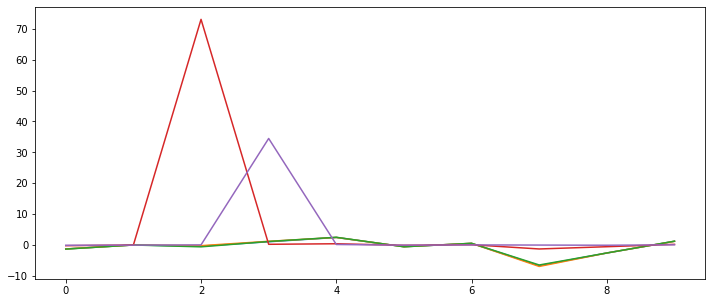

In [239]:
plt.figure()
plt.plot(df['Open'], label='open')
plt.plot(df['Close'], label='close')
plt.plot(df['High'], label='high')
plt.plot(df['Low'], label='low')
plt.plot(df['Volume'], label='low')


<AxesSubplot:>

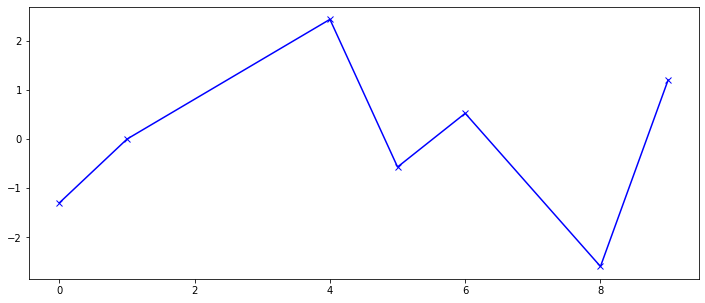

In [227]:
normal['Open'].plot(marker='x', color='b')

## 3) DBSCAN

In [240]:
from sklearn.cluster import DBSCAN

In [245]:
cluster=DBSCAN(eps=0.7, min_samples=2).fit(norm_resid)
cluster

DBSCAN(eps=0.7, min_samples=2)

In [260]:
import numpy as np
lb, cnt=np.unique(cluster.labels_,return_counts=True)
["{} label - {} count ".format(lb, cnt) for lb,cnt in zip(lb, cnt)]
#The zip() function takes iterables (can be zero or more), aggregates them in a tuple, and return it.


['-1 label - 44 count ',
 '0 label - 5595 count ',
 '1 label - 2 count ',
 '2 label - 2 count ',
 '3 label - 4 count ',
 '4 label - 2 count ',
 '5 label - 30 count ',
 '6 label - 3 count ',
 '7 label - 3 count ',
 '8 label - 3 count ',
 '9 label - 2 count ',
 '10 label - 2 count ']

In [250]:
cluster.labels_

array([ 0,  0,  0, ..., 10, 10, -1])